# Linear Regression (predictions from continuous data)

<i>By Diego Ramallo</i>

Here we'll try out a linear regression exercise on our own. This exercise will cover basic linear regression, ridge regression/lasso regression, and gradient descent. It will also include error determination, and cross-validation techniques. We will be following this template: http://facweb.cs.depaul.edu/mobasher/classes/csc478/Notes/IPython%20Notebook%20-%20Regression.html

## Understanding and organizing our data

In [1]:
#We'll import our sklearn model libraries
from sklearn.cross_validation import KFold, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Here we'll import our data from the sklearn library
from sklearn.datasets import load_boston

boston= load_boston()

In [3]:
#boston seems to be a dictionary, let's check the keys
#to see what kind of data we're working with
boston.keys()

['data', 'feature_names', 'DESCR', 'target']

In [4]:
#Great, we can see the relevant items for our machine learning
#tasks. Let's take data, target, and feature names
#and put them into a dataframe for easier viewing
bostonDF = pd.DataFrame(boston['data'], columns= boston['feature_names'])
bostonDF['target'] = boston['target']

In [5]:
bostonDF.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Great now we have a dataframe with all of our features and labels on the same data structure. In our tutorial we are directed to add an extra row of ones to do multiple regression. Let's do that for now as well. 

In [6]:
bostonDF['x0']= np.array(np.ones(len(bostonDF['target'])))#Using length of target as ref to make correct length x0 column

In [7]:
#Let's get a look at some of our data
bostonDF.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target,x0
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0,1.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6,1.0
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7,1.0
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4,1.0
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2,1.0


In [8]:
#Now let's get a description of our dataset
bostonDF.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target,x0
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.0
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806,1.0
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104,0.0
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000,1.0
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000,1.0
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000,1.0
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000,1.0
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000,1.0


## Splitting our datasets

In [9]:
#Now we'll split our data first into training/testing (wel'll further divide testing into validation, real test)
train, rest= train_test_split(bostonDF, test_size= 0.5, random_state= 42)#random_state sets seed
#If I had features/labels on different arrays say a= feature data and b = labe/response we'd use the following
#aTraining,bTraining, aTesting, bTesting = train_test_split(a, b, test_size= 0.25, random_state= 42)

In [10]:
#Now we'll split this further into validation and testing datasets
valid, test = train_test_split(rest, test_size = 0.5, random_state= 42)

#Verify that the lenths of our datasets are about 50/25/25 for train/valid/test
print len(train), len(valid), len(test)

253 126 127


## Implementing a basic regression model

In [11]:
#We'll start with linear regression before optimization
linReg0= LinearRegression()

In [12]:
#Now we'll fit our data using our features (all cols but 'target') and our response ('target')
linReg0.fit(train.ix[:, train.columns != 'target'], train['target'])# First argument selects everything but target column

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [13]:
#Now that' we have model, we can predict values using our validation set features

predVal= linReg0.predict(valid.ix[:, train.columns != 'target'])

In [14]:
#Now we can calculate our error 

absErr = abs(predVal-valid['target'])
MSE= sum(absErr**2)/len(predVal)
rootMSE= np.sqrt(MSE)
#Could also take the dot product of
#error with itself to give us the sum of squared errors, try next lines

#new= np.dot(absErr,absErr)
#np.sqrt(new/len(predVal))

#Let's also look at the median value for the true values
print 'The median value for our target values is: ', np.median(valid['target'])

print 'The MSE and RMSE error metrics for the validation set are \n MSE: %s \n RMSE: %s '% (MSE,rootMSE)#Could also use .format() for format strings

The median value for our target values is:  20.95
The MSE and RMSE error metrics for the validation set are 
 MSE: 19.5211901567 
 RMSE: 4.41827909448 


Thus, our error (from RMSE) is about 20% of our target value. We can explore this further by visualizing our true vs predicted values and our residual plot.

<IPython.core.display.Javascript object>


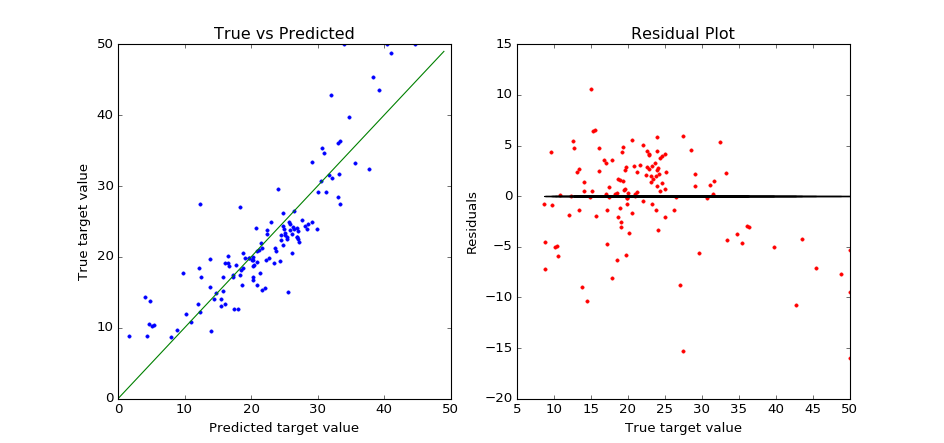

In [21]:
#We can plot the results of the predictions against the real values
#Good predictions should show a linear relationship with true values
%matplotlib nbagg

plt.subplot(1,2,1)
plt.plot(predVal, valid['target'], '.')
plt.plot(range(0,50),range(0,50), '-')#Plots ideal reference where y=x
plt.xlabel('Predicted target value')
plt.ylabel('True target value')
plt.title('True vs Predicted')

#Additionally, a residuals (predicted-true response) plot will tell us how far our predictions
#were from our validation responses

plt.subplot(1,2,2)
plt.plot(valid['target'], predVal-valid['target'], '.r')
plt.plot(valid['target'], np.zeros(len(valid['target'])), 'k-')
plt.xlabel('True target value')
plt.ylabel('Residuals')
plt.title('Residual Plot')

In [16]:
#Let's calculate the R-squared value 
import scipy
_, _, r_value, _, _ = scipy.stats.linregress(predVal, valid['target'])
print 'R-squared value: ', r_value**2#Squares r-value

R-squared value:  0.753085650845


As you can see from the 'True vs Predicted' plot, we only really get values close to the True target values near the center of our target range. Our R-squared score of 0.75 also shows a weaker correlation than we'd like (something closer to 1.0 would be preferable). Our 'Residual Plot' confirms this by showing that the difference between our predicted and true values can be quite large at times. <strong>Thus, our model could probably be improved by optimization steps</strong>.

## K-Fold Cross-Validation

Now we'll test the performance of our linear regression by 

In [17]:
#Ok first we'll append the validation data to our train data to further resplit with kfold
train2= train.append(valid)
print len(train), len(valid), len(train2)
train2.head(3)

253 126 379


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target,x0
475,6.39312,0.0,18.10,0.0,0.584,6.162,97.4,2.2060,24.0,666.0,20.2,302.76,24.10,13.3,1.0
299,0.05561,70.0,2.24,0.0,0.400,7.041,10.0,7.8278,5.0,358.0,14.8,371.58,4.74,29.0,1.0
296,0.05372,0.0,13.92,0.0,0.437,6.549,51.0,5.9604,4.0,289.0,16.0,392.85,7.39,27.1,1.0


In [18]:
#Note: we're working with pandas indices but these were shuffled up at the beginning,
#they don't match the indices that our KFold object utilizes. Better to turn them into a numpy array first
train2X= train.ix[:, train.columns != 'target'].as_matrix()
train2Y= train['target'].as_matrix()

In [19]:
#Now we'll use these arrays to define the K-Fold splits. The number determines the amount of
#bias and variance you'd like in your predictions. Typically, larger folds is better if you have 
#enough samples. Since we have less tha 500 here, I'll keep it at 5 (3, 5, and 10 is common)

kf= KFold(len(train2X), n_folds= 5, shuffle= False, random_state= 42)
kf

sklearn.cross_validation.KFold(n=253, n_folds=5, shuffle=False, random_state=42)

In [23]:
#Now we'll apply the same error estimation that we did before to each split
rmseList= []#Initialize list to hold rmse scores

#Apply linear regression to each fold, predict and calculate RMSE
for trainKF, testKF in kf:
    #Train on a subset of training/val set using the training indices of different folds
    linReg0= LinearRegression()
    linReg0.fit(train2X[trainKF], train2Y[trainKF])
    
    #Predict on a subset of data using the testing indices
    predKF= linReg0.predict(train2X[testKF])
    
    #Calculate error from predicted values and testing indices
    error= predKF-train2Y[testKF]#These indices may not make sense cause we
    
    #Calculate the RMSE and append to our list of RMSE's
    rmseKF=  np.sqrt(np.dot(error,error)/len(valid['target']))
    print 'RMSE: ', rmseKF
    rmseList.append(rmseKF)
rmseAverageKF= np.mean(rmseList)
print 'Our mean RMSE from K-Fold validation is: ', rmseAverageKF

RMSE:  2.74357710345
RMSE:  3.29125370268
RMSE:  2.90382984194
RMSE:  2.91018072184
RMSE:  3.35643804317
Our mean RMSE from K-Fold validation is:  3.04105588262


In [24]:
#Let's compare this to what we got by training on the train set and testing on the validation set
print 'RMSE single fold: ', rootMSE
print 'RMSE k-fold: ', rmseAverageKF

RMSE single fold:  4.41827909448
RMSE k-fold:  3.04105588262


In [ ]:
kf

In [ ]:
#This is how we'd append rows to a array/matrix 
a= np.ones([2,3])
b= np.zeros([2,3])
np.concatenate([a,b])

In [ ]:
train2= train.append(valid)
print len(train), len(valid), len(train2)

NameError: name 'np' is not defined